## Paquetes

In [1]:
import pandas as pd
import openpyxl
from tqdm import tqdm
import unidecode
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import warnings
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import math
from operator import itemgetter

import unidecode
import string
import re
from fuzzywuzzy import fuzz
import os
import traceback
from scipy.stats import ttest_ind

import rddensity
from rdrobust import rdrobust,rdbwselect,rdplot
import statsmodels.api as sm
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm

In [2]:
#PRUEBA GRÁFICA PARA CADA AÑO, 20111, 15 Y 19

#PARA CADA AÑO, VER QUE PASA EN LOS t's siguientes con la discontinua
#HACER GRAFICA DE DISPESIÓN
#CORRER REGRESIÓN PARA CERO DERIVADA, KERNEL TRIANGULAR, KERNEL UNIFORME, P1 Y P2
#CORRER REGRESIÓN PARA PRIMER DERIVADA, KERNEL TRIANGULAR, KERNEL UNIFORME, P1 Y P2


#DIF EN DIF PARA 2011

## Procesamiento de data electoral

In [226]:
################################################################################################################
#PARAMETROS
año_t0 = 2011      #PERIODO DE TRIUNFO EN PRIMER ELECCIÓN
año_t1 = año_t0 + 4 #PERIODO DE REPETICIÓN O NO REPETICIÓN
años_ev = [año_t1+1, año_t1+2, año_t1+3, año_t1+4] #AÑOS CONSIGUIENTES DESPUES DE LA REPETICIÓN

In [227]:
data_electoral_procesada = "OUT_1_DATA_ELECTORAL_PROCESADA"
data_electoral_raw = "INPUT_1_DATA_ELECTORAL"
partidos = pd.read_excel(f"{data_electoral_procesada}//Partidos_Electorales_Long.xlsx")

In [228]:
carpeta1 = "OUT_2_TESTS"
if not os.path.exists(carpeta1):
    os.makedirs(carpeta1)

### Procesamiento según los parámetros

General

In [236]:
################################################################################################################
# PROCESAMIENTO DE LOS DATOS ELECTORALES

################################################################################################################
# PRIMER PERIODO
dfg = pd.read_stata(f"{data_electoral_raw}/Alcaldías/{año_t0}_alcaldia.dta")
df = dfg.copy()

nulos = df[["codmpio", "codigo_lista"]]
nulos = nulos[nulos["codigo_lista"]==998]
nulos.columns = ["codmpio", "votos_nulos"]
df = df.sort_values(by = ["codmpio", "votos"], ascending= [True, False])
df = pd.merge(df, nulos, "left", "codmpio")

df["votos_porcentaje"] = df["votos"]/(df["censoe_total"]-df["votos_nulos"])
df[f"votos_segundo"] = df.groupby(["codmpio"]).shift(-1)["votos_porcentaje"]

df = df[df.curules == 1]
df = df.rename(columns = {"votos_porcentaje": "votos_primero"})

df = df[['ano', 'municipio', 'codmpio', 'codigo_partido', 'primer_apellido', 'votos_primero', 'votos_segundo']]
dff = df.copy()
dff = dff.merge(partidos, "left", "codigo_partido")

dff.columns = [col if col in ['codmpio', 'municipio', 'miembros_code'] else f'{col}_{año_t0}' for col in dff.columns]

#################################################################################################################
# SEGUNDO PERIODO
dfg = pd.read_stata(f"{data_electoral_raw}/Alcaldías/{año_t1}_alcaldia.dta")

df = dfg.copy()

nulos = df[["codmpio", "codigo_lista"]]
nulos = nulos[nulos["codigo_lista"]==998]
nulos.columns = ["codmpio", "votos_nulos"]
df = df.sort_values(by = ["codmpio", "votos"], ascending= [True, False])
df = pd.merge(df, nulos, "left", "codmpio")

df["votos_porcentaje"] = df["votos"]/(df["censoe_total"]-df["votos_nulos"])
df = df[['ano', 'codmpio', 'codigo_partido', 'primer_apellido', 'curules','votos_porcentaje']]
df[f"votos_segundo"] = df.groupby(["codmpio"]).shift(-1)["votos_porcentaje"]

primeros = df[df.curules==1]
primeros = primeros[["ano", "codmpio", "votos_porcentaje"]]
primeros.columns = ["ano", "codmpio", "votos_primero"]

df = pd.merge(df, primeros, "left",  ["ano", "codmpio"])
df["diferencia"] = np.where(df["curules"] == 0, df["votos_porcentaje"] - df["votos_primero"], df["votos_porcentaje"] - df["votos_segundo"])

df_long = df.merge(partidos, "left", "codigo_partido") #AQUI SI HAY MÁS DE UN PARTIDO EN UNA COALICIÓN Y ESA COALICIÓN GANA ENTONCES A CADA PARTIDO LE APARECE UN 1 EN CURULES
df_long.columns = [col if col in ['codmpio', 'miembros_code'] else f'{col}_{año_t1}' for col in df_long.columns]

################################################################################################################ LOS QUE GANARON EN T-4, ¿QUE LES PASO EN LA SIGUIENTE ELECCIÓN?
dff = dff.merge(df_long, "left", ["codmpio", "miembros_code"])
dff = dff.sort_values(by = ["codmpio", f"curules_{año_t1}"], ascending = [True, False]).drop_duplicates(["codmpio"])
dff = dff[dff[f"curules_{año_t1}"].notna()]

# dff[f"curules_{año_t1}"].sum()

Concejos

In [237]:
#CODIGO PARTIDO 2015 ES LA COALICIÓN (para MUNICIPIO 5134, EL LIBERAL (19910006.0) EN 2011 ESTUVO EN LA COALICIÓN GANADORA EN 2015 (20150010.0))

# PROCESAMIENTO DE CONCEJOS (PROPORCIÓN DE VOTOS POR PARTIDO)
concejo = pd.read_stata(f"INPUT_1_DATA_ELECTORAL/Concejos/{año_t1}_concejo.dta")
concejoc = concejo.groupby(["codmpio", "codigo_partido"])[["curules"]].sum().reset_index()
curules_totales = concejo.groupby(["codmpio"])[["curules"]].sum().reset_index(); curules_totales.columns = ["codmpio", "curules_totales"]
concejoc = concejoc.merge(curules_totales, "left", "codmpio")
concejoc["curules_share"] = concejoc["curules"]/concejoc["curules_totales"]

dffp = dff[["codmpio", f"codigo_partido_{año_t1}"]] #DATAFRAME FINAL, SOLO CON EL CODIGO DEL MUNICIPIO + EL CODIGO DE LA COALICIÓN (2015)
dffp.columns = ["codmpio", "codigo_partido"] #CAMBIAR EL NOMBRE, 760 REGISTROS
dffp = dffp.merge(partidos, "left", "codigo_partido") #PEGUE CON EL DATAFRAME DE PARTIDOS (VAN A QUEDAR MÁS REGISTROS, POR LAS COALICIONES)
concejoc = concejoc.rename(columns = {"codigo_partido":"miembros_code"}) #CAMBIO EL NOMBRE A MIEMBROS PORQUE EN CONCEJO TIENE LOS VOTOS POR PARTIDOS (NO X COALICIÓN)
dffp = dffp.merge(concejoc, "left", ["codmpio", "miembros_code"])
dffp = dffp.groupby(["codmpio", "codigo_partido"])[["curules_share"]].sum().reset_index()
dffp.columns = ["codmpio", f"codigo_partido_{año_t1}", f"curules_share_{año_t1}"]

In [238]:
dff = dff.merge(dffp, "left", ["codmpio", f"codigo_partido_{año_t1}"])

In [239]:
dff = dff[["codmpio", f"votos_porcentaje_{año_t1}", f"diferencia_{año_t1}", 
           f"miembros_clean_{año_t1}", f"tipo_{año_t1}", f"curules_share_{año_t1}"]]

Nombramiento de columnas

In [240]:
dffg = dff[np.abs(dff[f"votos_porcentaje_{año_t1}"])<=1]
dffg = dffg[np.abs(dffg[f"diferencia_{año_t1}"])<=1]

dffg["votos_complemento"] = dff[f"votos_porcentaje_{año_t1}"] - dffg[f"diferencia_{año_t1}"]
dffg["total votos"] = dffg["votos_complemento"] + dff[f"votos_porcentaje_{año_t1}"]
dffg= dffg[dffg["total votos"]<=1]

In [241]:
# dffg[["codmpio", f"diferencia_{año_t1}"]].to_excel(f"OUT_2_TESTS/{año_t1}_X.xlsx", index = False)

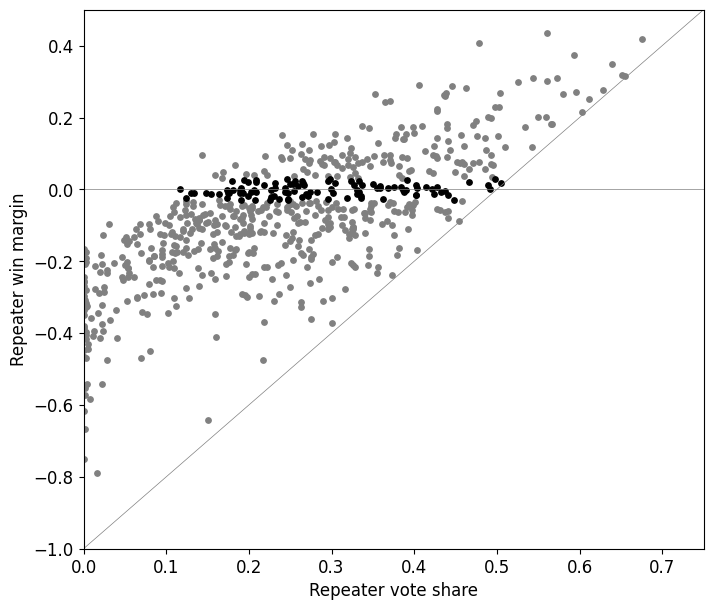

In [242]:
# Dibuja la figura con el tamaño especificado
plt.figure(figsize=(8, 7))  # Set the figure size

# Separa los puntos que están en el rango de -0.1 a 0.1 en y
mask = (dffg[f"diferencia_{año_t1}"] >= -0.03) & (dffg[f"diferencia_{año_t1}"] <= 0.03)
outside_range = dffg[~mask]
inside_range = dffg[mask]

# Puntos fuera del rango en gris
plt.scatter(outside_range[f"votos_porcentaje_{año_t1}"], outside_range[f"diferencia_{año_t1}"], alpha=1, color='grey', s = 15)
plt.scatter(inside_range[f"votos_porcentaje_{año_t1}"], inside_range[f"diferencia_{año_t1}"], alpha=1, color='black',  s = 15)

# Valores para la línea de y = -1 + 2x
x_vals = np.array([0, 1])
y_vals = -1 + 2 * x_vals
plt.plot(x_vals, y_vals, color='gray', linestyle='-', linewidth=0.5)
plt.xlabel("Repeater vote share")
plt.ylabel("Repeater win margin")

# Establece los límites de los ejes como se ha solicitado
plt.xlim(0, 0.75)
plt.ylim(-1, 0.5)
plt.axhline(0, color='gray', linewidth=0.5)

# plt.savefig(f"{carpeta1}/vote_share_win_margin.png", dpi = 300)

### Base de dependientes y controles

In [243]:
variables = "INPUT_2_DATAMUNICIPAL"
dependientes = pd.read_csv(f"{variables}//dependientes.csv")
dependientes = dependientes[["codmpio", "date", "deuda_pc"]]
# controles = pd.read_stata(f"{variables}//PANEL_CEDE_CONTROLES.dta")

In [244]:
controles = pd.read_csv(f"{variables}//controles.csv")
controles = controles.rename(columns={"ano":"date"})

ids = ["codmpio", "date"]
inst_hist = ['ao_crea', 'dist_creal']
inst_cont = ['indrural', 'discapital', 's11_total']
fiscal    = ['DF_ahorro', 'DF_desemp_fisc', 'DI_eficacia', 'DI_eficiencia', 'DI_capadmin', 'DI_desemp_int']
geo       = ['areaoficialkm2', 'pobl_tot', 'altura', 'lat', 'long', 'dmagdalena', 'dcauca', 'dcosta']
fex       = ['gandina', 'gcaribe', 'gpacifica','gorinoquia', 'gamazonia', 'coddepto']

lista_controles = inst_hist + inst_cont + fiscal + geo + fex 

controles = controles[ids + lista_controles]

In [245]:
df = pd.merge(dependientes, dff, "inner", ["codmpio"])
df = pd.merge(df, controles, "inner", ["codmpio", "date"])

## Test de balanceo

In [246]:
año_control  = 2015

# List to hold results
results = []
# print(año_control-4, año_control)

for Y in df:
    
    # dfmedias = df[(df.date>=año_control-4) & (df.date<año_control)]
    dfmedias = df[(df.date>=año_control)]
    # dfmedias

    try:
        XT = dfmedias[dfmedias[f"diferencia_{año_t1}"] >= 0][Y].dropna()
        XN = dfmedias[dfmedias[f"diferencia_{año_t1}"] < 0][Y].dropna()

        mean_XT = XT.mean()
        mean_XN = XN.mean()
        diff_means = mean_XT - mean_XN

        t_stat, p_value = ttest_ind(XT, XN)

        results.append([Y, mean_XT, mean_XN, diff_means, p_value])

    except:
        None

# Convert results into a DataFrame
results_df = pd.DataFrame(results, columns=['Variable', 'Mean_XT', 'Mean_XN', 'Difference', 'P-value'])
results_df.to_excel(f"{carpeta1}/balanceo.xlsx")


## Prueba de densidad (McCrary)

In [247]:
from scipy.stats import norm

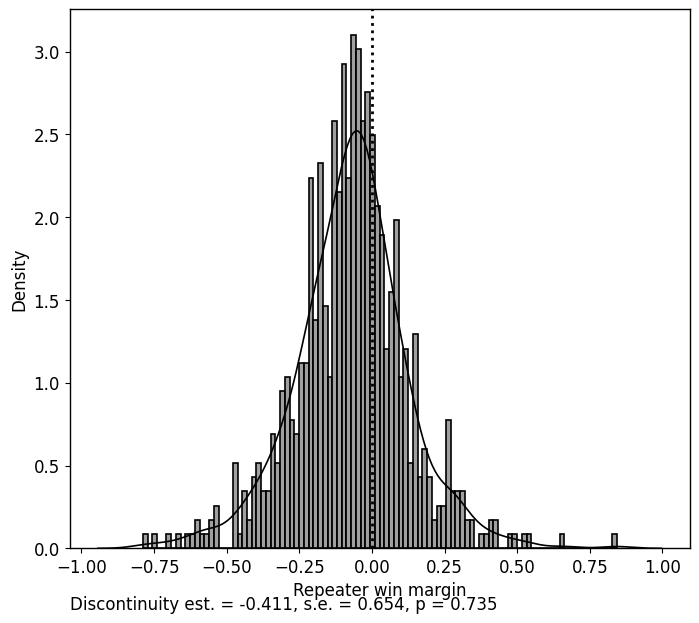

In [248]:
dfm = df[df.date == año_t1]
dfm = dfm[np.abs(dfm[f"diferencia_{año_t1}"])<abs(1)]
RV = dfm[f"diferencia_{año_t1}"].dropna()

rdd = rddensity.rddensity(X=RV)
DIF = round(rdd.hat["diff"],3)
EE = round(rdd.sd_jk["diff"],3)
Z = DIF/EE
PMCRARY = round(1 - norm.cdf(Z),3)

texto = f"Discontinuity est. = {DIF}, s.e. = {EE}, p = {PMCRARY}"

plt.figure(figsize=(8, 7))  # Set the figure size
plt.axvline(0, color='black', linestyle='dotted', linewidth=2)
sns.histplot(RV, bins=100, stat="density", color="gray", kde=False, edgecolor="black", linewidth = 1.2)
sns.kdeplot(RV, color="black", linewidth = 1.2)
plt.xlabel('Repeater win margin')
plt.ylabel('Density')
plt.grid(False)
spines_to_set = ['top', 'right', 'bottom', 'left']
for spine in spines_to_set:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_linewidth(1)  # Establece el grosor de la línea
    plt.gca().spines[spine].set_edgecolor('black')  # Establece el color de la línea

plt.text(0, -0.12, texto, transform=plt.gca().transAxes, ha='left', va='bottom')

# plt.to_excel(f"{carpeta}/histogram")
plt.savefig(f"{carpeta1}/Mcrary.png", dpi = 300)

plt.show()




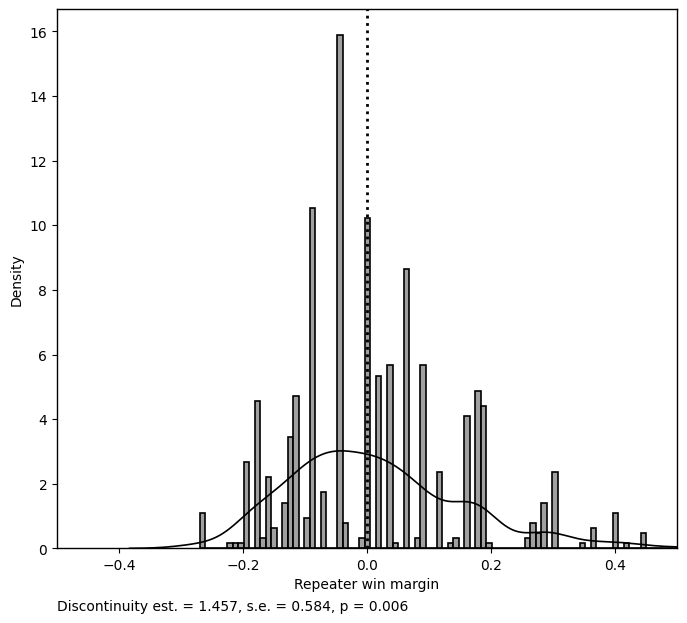

In [249]:
dfm = df[df.date == año_t1]
dfm = dfm[np.abs(dfm[f"curules_share_{año_t1}"])<abs(1)]
RV = dfm[f"curules_share_{año_t1}"].dropna() - 0.27

rdd = rddensity.rddensity(X=RV)
DIF = round(rdd.hat["diff"],3)
EE = round(rdd.sd_jk["diff"],3)
Z = DIF/EE
PMCRARY = round(1 - norm.cdf(Z),3)

texto = f"Discontinuity est. = {DIF}, s.e. = {EE}, p = {PMCRARY}"

plt.figure(figsize=(8, 7))  # Set the figure size
plt.rcdefaults()
plt.axvline(0, color='black', linestyle='dotted', linewidth=2)
sns.histplot(RV, bins=100, stat="density", color="gray", kde=False, edgecolor="black", linewidth = 1.2)
sns.kdeplot(RV, color="black", linewidth = 1.2)
plt.xlabel('Repeater win margin')
plt.ylabel('Density')
plt.grid(False)
spines_to_set = ['top', 'right', 'bottom', 'left']
for spine in spines_to_set:
    plt.gca().spines[spine].set_visible(True)
    plt.gca().spines[spine].set_linewidth(1)  # Establece el grosor de la línea
    plt.gca().spines[spine].set_edgecolor('black')  # Establece el color de la línea

plt.text(0, -0.12, texto, transform=plt.gca().transAxes, ha='left', va='bottom')

# plt.to_excel(f"{carpeta}/histogram")
# plt.savefig(f"{carpeta1}/Mcrary.png", dpi = 300)

plt.xlim(-0.5,0.5)

plt.show()


## Regresion principal: margen ganador

### Carpeta

In [250]:
carpeta2 = "OUT_4_RD_TABLES"
if not os.path.exists(carpeta2):
    os.makedirs(carpeta2)

### Organización base + parametros

In [251]:
def imputar_percentil(geohistf):
    for column in geohistf.columns:
        if geohistf[column].isna().any():
            # Calcular el percentil 76 para la columna actual
            percentile_76 = np.percentile(geohistf[column].dropna(), 50)
            # Imputar este percentil donde haya NaNs
            geohistf[column].fillna(percentile_76, inplace=True)
    return geohistf

In [252]:
#PARAMETROS
limite = 1
threshold = 0
año = año_t1+1
Y = "deuda_pc"

#FIX BASELINE BASE
d = df[(df.date==año)]
d["X"] = d[f"diferencia_{año_t1}"].copy()
d["Y"] = d[Y]
d = d[np.abs(d["X"])<=limite]
d['const'] = 1
d["T"] = d["X"].apply(lambda x: 1 if x>=threshold else 0)
d['XT'] = d['X'] * d['T']

dptos = pd.get_dummies(d.coddepto, prefix="dpto", drop_first="True")
d = d.drop(columns = "coddepto"); d = pd.concat([d,dptos],axis = 1)
departamentos = list(dptos.columns)

d = imputar_percentil(d)


dd = d[["Y", "X", "T", "XT"]].dropna()

est1 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "uniform", all = True, vce='hc0',  c=threshold); b_optimo = est1.bws.loc["b"][0]

# est1 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "uniform", all = True, h = 100, vce='hc0',  c=threshold) #lineal, OLS
# sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']]).fit().summaty()
# sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']]).fit(cov_type="HC3").summary2()
# A = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']])
# A.fit?
# sm.OLS(np.log(dd['Y']+1), dd[['const', 'X', 'T', 'XT']]).fit().summary2()
# sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT', 'Tcoal', 'Xcoal', 'XTcoal']]).fit().summary2()
# sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT', 'Tcons', 'Xcons', 'XTcons']]).fit().summary2()
# sm.OLS(np.log(dd['Y']), dd[['const', 'cons', 'T', 'Tcons']]).fit().summary2()
# sm.OLS(np.log(dd['Y']+1), dd[['const', 'coal', 'T', 'Tcoal']]).fit().summary2()

# k = dd[dd["T"]==0]
# C = sm.OLS(k['Y'], k[['const', 'X']]).fit()
# C.summary()
# A = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']]).fit()
# B = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XA']]).fit()
# A.summary()
# B.summary()
# 0.1829-0.1854
# regresion_tablav2(B.summary2(), results, variables, round(b,3), 0)
# regresion_tablav1(A.summary2(), results, variables, round(b,3), 0)

# mserd, msetwo, msesum, msecomb1, msecomb2, cerrd, certwo, cersum, cercomb1, cercomb2

### Funciones claves

In [253]:
#FUNCIÓN PARA LA SIGNIFICANCIA

def significance(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''

#FUNCIÓN PARA LA REGRESION y ORGANIZARLA EN LAS TABLAS QUE NECESITAMOS
def regresion_tablav2(sumario, results, variables, bandwidth, media_dependiente):
    # Suponiendo que 'sumario' y 'results' son objetos ya definidos y accesibles

    # Extracción de datos
    N = sumario.tables[0].iloc[3,1]
    R = sumario.tables[0].iloc[6,1]

    # Creación y modificación de coef_df
    coef_df = sumario.tables[1][["Coef.", "Std.Err.","P>|t|"]]
    coef_df = coef_df.T[["const", "X", "T", "XT"]].T

    # Aplicar formato y agregar nuevas columnas
    coef_df['p'] = coef_df['P>|t|'].apply(significance)
    coef_df["coef"] = coef_df.apply(lambda row: f"{round(row['Coef.'], 3)}{row['p']}", axis=1)
    coef_df["std"] = coef_df["Std.Err."].round(3).apply(lambda x: f"({x})")

    # # Seleccionar y reordenar columnas
    coef_df = coef_df[["coef", "std"]].loc[["X", "T", "XT"]]

    # Reestructuración final del DataFrame
    coef_df = pd.DataFrame({"coef/std": coef_df.stack()}).reset_index(level=1, drop=True)

    coef_df.loc["e1"] = [""]
    coef_df.loc["e2"] = [""]
    coef_df.loc["Outcome mean"] = media_dependiente
    coef_df.loc["Bandwith"] = bandwidth
    coef_df.loc["R2"] = R
    coef_df.loc["Observations"] = N

    return coef_df

### Regresión variando controles

In [254]:
fex  = ['gandina', 'gcaribe', 'gpacifica','gorinoquia', 'gamazonia'] + departamentos
lista_controles2 = [[], inst_hist , inst_hist + inst_cont , inst_hist + inst_cont + fiscal,  inst_hist + inst_cont + fiscal + geo, inst_hist + inst_cont + fiscal + geo + fex]
lista_controles_completa = inst_hist + inst_cont + fiscal + geo + fex

In [255]:
tabla_regresion = pd.DataFrame()
for lista in lista_controles2:
    # print(lista)
    dd = d[["Y", "const", "X", "T", "XT"]+lista].dropna()
    media = round(dd["Y"].mean(),3)
    # dd["Y"] = np.log(1+dd["Y"])
    model = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']+lista]).fit()
    sumario = model.summary2()
    variables = list(sumario.tables[1].index)
    tabla = regresion_tablav2(sumario, results, variables, "1", media)
    tabla_regresion = pd.concat([tabla_regresion, tabla], axis = 1)

In [256]:
tabla_regresion.to_excel(f"{carpeta2}/0REGCONTROL.xlsx")
tabla_regresion

,coef/std,coef/std,coef/std,coef/std,coef/std,coef/std
X,0.006,0.007,-0.013,-0.012,-0.003,-0.024
X,(0.06),(0.06),(0.06),(0.06),(0.06),(0.061)
T,-0.014,-0.015,-0.01,-0.009,-0.011,-0.008
T,(0.021),(0.022),(0.021),(0.021),(0.021),(0.021)
XT,0.364***,0.361***,0.388***,0.385***,0.367***,0.414***
XT,(0.113),(0.113),(0.113),(0.113),(0.113),(0.115)
e1,,,,,,
e2,,,,,,
Outcome mean,0.078,0.078,0.078,0.078,0.078,0.078
Bandwith,1,1,1,1,1,1


#### Gráfica

In [257]:
dk = dd.copy()
# dk["Y"] = np.log(1+dk["Y"])
model = sm.OLS(dk['Y'], dk[['const', 'X', 'T', 'XT']]).fit()
model2 = sm.OLS(dk['Y'], dk[['const', 'X', 'T', 'XT']+lc]).fit()
K = pd.DataFrame()
# K["Y"] = dk["Y"].values
K["Y"] = model2.predict()
K["X"] = dk["X"].values
K["y_pred"] = model.predict()
params = model.params

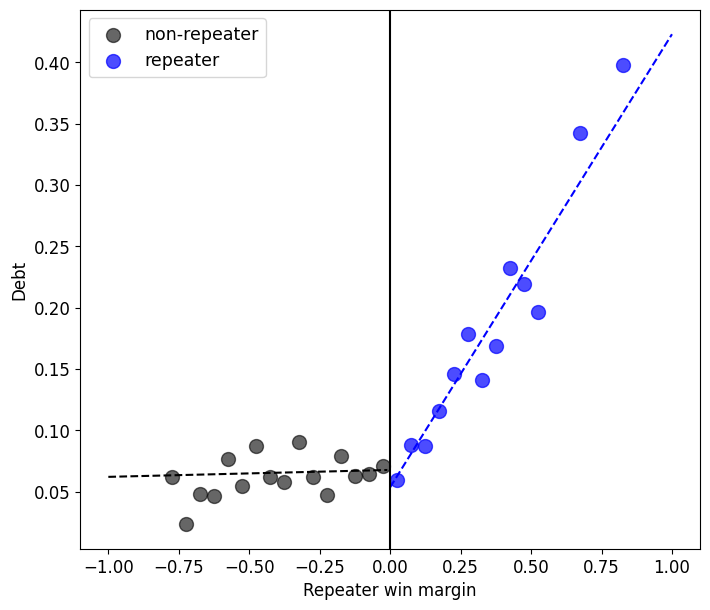

In [258]:
# Crear bines para X
plt.figure(figsize=(8, 7)) 

plt.rcParams.update({'font.size': 12})  

bin_size = 0.05
bins = np.arange(-1, 1 + bin_size, bin_size)
K['bin'] = pd.cut(K['X'], bins, labels=(bins[:-1] + bin_size / 2), right=False)

grouped = K.groupby('bin')[["Y", "y_pred"]].mean().reset_index()
grouped['bin'] = grouped['bin'].astype(float)

before_threshold = grouped[grouped['bin'] < threshold]
after_threshold = grouped[grouped['bin'] >= threshold]

plt.scatter(before_threshold['bin'], before_threshold['Y'], color='black', alpha=0.6, s = 100, label = "non-repeater")
plt.scatter(after_threshold['bin'], after_threshold['Y'], color='blue', alpha=0.7, s = 100, label = "repeater")

X_before = np.linspace(-1, 0, 100, endpoint=False)
X_after = np.linspace(0, 1, 100)
Y_before = params['const'] + params['X'] * X_before  # Para X < 0
Y_after = (params['const'] + params['T']) + (params['X'] + params['XT']) * X_after  # Para X >= 0

# plt.plot(X_before, Y_before, color='black', linestyle='--', label=r'$\haty_i=\alpha+\beta x_i+\epsilon_{i\ }$')
# plt.plot(X_after, Y_after, color='blue', linestyle='--', label=r'$\haty_i=\alpha+\beta x_i+\tau t_i+\phi t_ix_i+\epsilon_{i\ }$')

plt.plot(X_before, Y_before, color='black', linestyle='--')
plt.plot(X_after, Y_after, color='blue', linestyle='--')

plt.axvline(x=threshold, color='black', linestyle='-')

plt.xlabel('Repeater win margin')
plt.ylabel('Debt')

plt.legend(fontsize=12.5)

### Regresión variando bandwidths

In [259]:
bandas = [1,1,b_optimo, b_optimo, b_optimo/2, b_optimo*2]
bandas = [1,1,b_optimo, b_optimo,  b_optimo,  b_optimo]
controles = [0,1,0,1,0,1]
dh = [0,0,0,0,1,1]

tabla_regresion = pd.DataFrame()

for b,c,dk in zip(bandas, controles, dh):
    
    dr = d.copy()
    # dr = dr[dr["Y"]>0]
    
    if b<1:
        if dk==1:
            dr = dr[np.abs(dr["X"])>=b]

        else:
             dr = dr[np.abs(dr["X"])<=b]

    cont = []

    if c == 0:
        cont = []
    
    else:
        cont = lista_controles_completa.copy()

    media = round(dr["Y"].mean(),3)
    # dr["Y"] = np.log(1+dr["Y"])

    model = sm.OLS(dr['Y'], dr[['const', 'X', 'T', 'XT']+cont])
    results = model.fit()
    sumario = results.summary2()
    variables = list(sumario.tables[1].index)

    tabla = regresion_tablav2(sumario, results, variables, round(b,3), media)

    tabla_regresion = pd.concat([tabla_regresion, tabla], axis = 1)

In [260]:
tabla_regresion.to_excel(f"{carpeta2}/1REGBAND.xlsx")
tabla_regresion

,coef/std,coef/std,coef/std,coef/std,coef/std,coef/std
X,0.006,-0.024,0.126,0.076,-0.003,-0.075
X,(0.06),(0.061),(0.187),(0.182),(0.118),(0.125)
T,-0.014,-0.008,0.001,0.008,-0.066,-0.047
T,(0.021),(0.021),(0.019),(0.018),(0.065),(0.068)
XT,0.364***,0.414***,-0.043,0.023,0.547**,0.633**
XT,(0.113),(0.115),(0.301),(0.288),(0.234),(0.247)
e1,,,,,,
e2,,,,,,
Outcome mean,0.078,0.078,0.073,0.073,0.083,0.083
Bandwith,1,1,0.118,0.118,0.118,0.118


#### Gráficas regresión principal (por año):

In [261]:
carpeta3 = "OUT_3_RD_GRAPHS"
if not os.path.exists(carpeta3):
    os.makedirs(carpeta3)

Regresiones

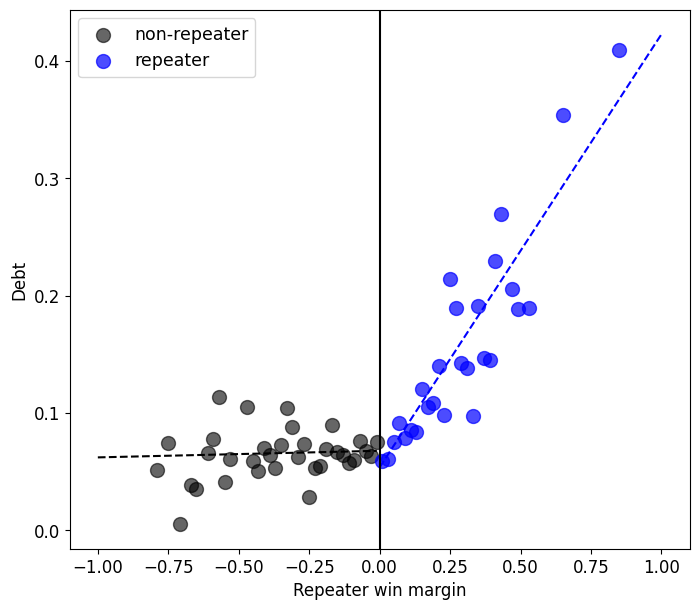

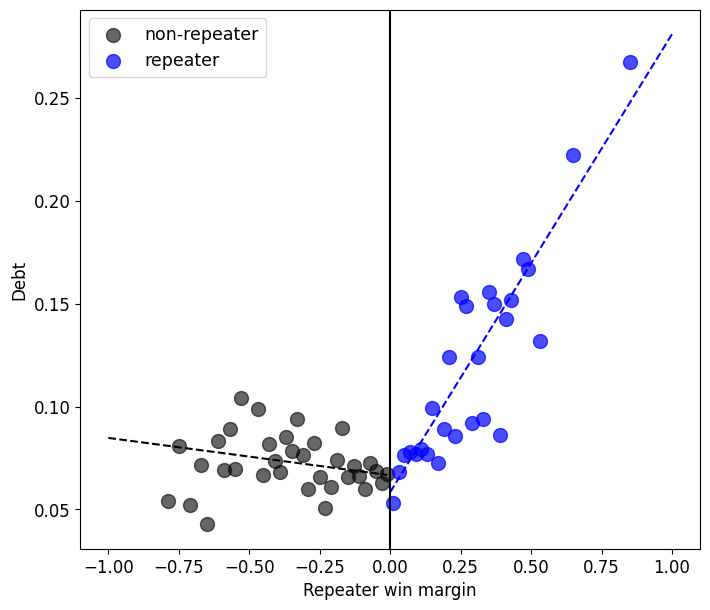

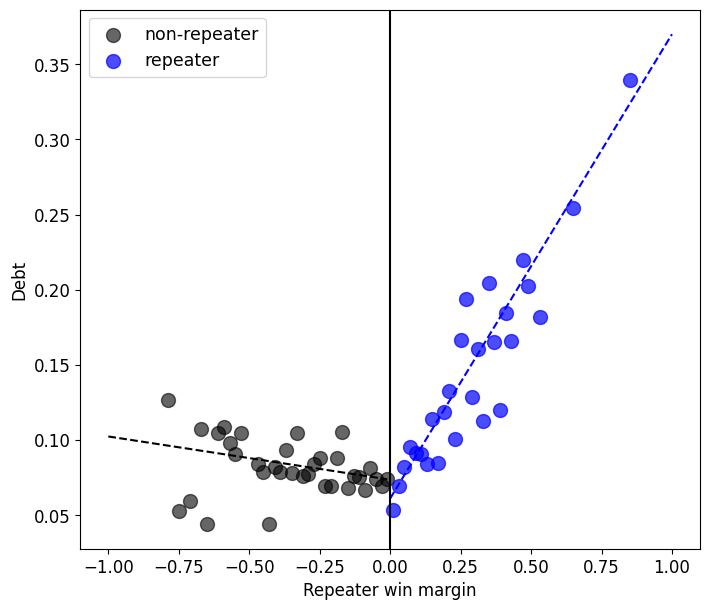

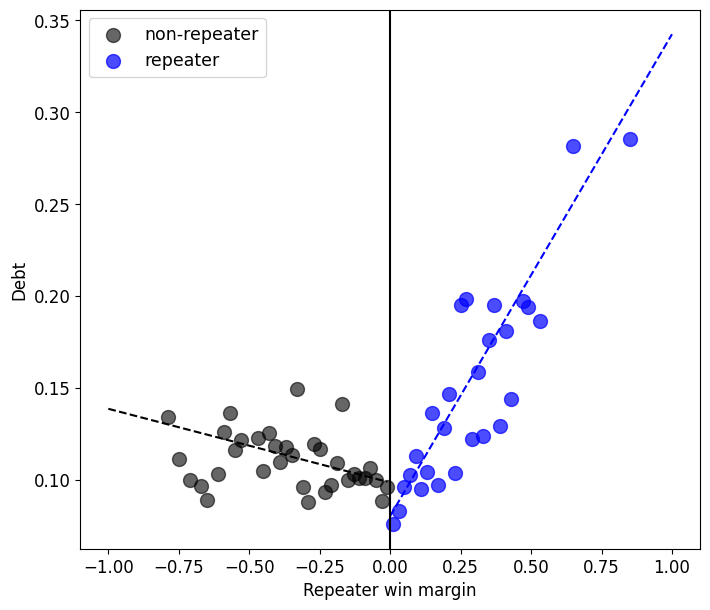

In [262]:
tabla_regresion = pd.DataFrame()

for year in range(año_t1+1,año_t1+5):

    lc = lista_controles_completa.copy()

    # print(year)

    limite = 1
    threshold = 0
    Y = "deuda_pc"

    #FIX BASELINE BASE
    dkk = df[(df.date==year)]


    columns_to_drop = [col for col in dkk.columns if dkk[col].isnull().sum() > 100]
    dkk = dkk.drop(columns=columns_to_drop)
    lc = [col for col in lc if col not in columns_to_drop]


    dkk["X"] = dkk[f"diferencia_{año_t1}"].copy()
    dkk["Y"] = dkk[Y]
    dkk = dkk[np.abs(dkk["X"])<=limite]
    dkk['const'] = 1
    dkk["T"] = dkk["X"].apply(lambda x: 1 if x>=threshold else 0)
    dkk['XT'] = dkk['X'] * dkk['T']

    dptos = pd.get_dummies(dkk.coddepto, prefix="dpto", drop_first="True")
    dkk = dkk.drop(columns = "coddepto"); dkk = pd.concat([dkk,dptos],axis = 1)
    departamentos = list(dptos.columns)
    dkk = imputar_percentil(dkk)

    ddk = dkk[["Y", "const", "X", "T", "XT"]+lc].dropna()
    media = round(ddk["Y"].mean(),3)
    model = sm.OLS(ddk['Y'], ddk[['const', 'X', 'T', 'XT']+lc]).fit()
    sumario = model.summary2()
    variables = list(sumario.tables[1].index)
    tabla = regresion_tablav2(sumario, results, variables, "1", media)
    tabla_regresion = pd.concat([tabla_regresion, tabla], axis = 1)

####################################################################################################
    dk = ddk.copy()
    # dk["Y"] = np.log(1+dk["Y"])
    model = sm.OLS(dk['Y'], dk[['const', 'X', 'T', 'XT']]).fit()
    model2 = sm.OLS(dk['Y'], dk[['const', 'X', 'T', 'XT']+lc]).fit()
    K = pd.DataFrame()
    # K["Y"] = dk["Y"].values
    K["Y"] = model2.predict()
    K["X"] = dk["X"].values
    K["y_pred"] = model.predict()
    params = model.params


    plt.figure(figsize=(8, 7)) 

    plt.rcParams.update({'font.size': 12})  

    bin_size = 0.02
    bins = np.arange(-1, 1 + bin_size, bin_size)
    K['bin'] = pd.cut(K['X'], bins, labels=(bins[:-1] + bin_size / 2), right=False)

    grouped = K.groupby('bin')[["Y", "y_pred"]].mean().reset_index()
    grouped['bin'] = grouped['bin'].astype(float)

    before_threshold = grouped[grouped['bin'] < threshold]
    after_threshold = grouped[grouped['bin'] >= threshold]

    plt.scatter(before_threshold['bin'], before_threshold['Y'], color='black', alpha=0.6, s = 100, label = "non-repeater")
    plt.scatter(after_threshold['bin'], after_threshold['Y'], color='blue', alpha=0.7, s = 100, label = "repeater")

    X_before = np.linspace(-1, 0, 100, endpoint=False)
    X_after = np.linspace(0, 1, 100)
    Y_before = params['const'] + params['X'] * X_before  # Para X < 0
    Y_after = (params['const'] + params['T']) + (params['X'] + params['XT']) * X_after  # Para X >= 0

    # plt.plot(X_before, Y_before, color='black', linestyle='--', label=r'$\haty_i=\alpha+\beta x_i+\epsilon_{i\ }$')
    # plt.plot(X_after, Y_after, color='blue', linestyle='--', label=r'$\haty_i=\alpha+\beta x_i+\tau t_i+\phi t_ix_i+\epsilon_{i\ }$')

    plt.plot(X_before, Y_before, color='black', linestyle='--')
    plt.plot(X_after, Y_after, color='blue', linestyle='--')

    plt.axvline(x=threshold, color='black', linestyle='-')

    plt.xlabel('Repeater win margin')
    plt.ylabel('Debt')

    plt.legend(fontsize=12.5)

    plt.savefig(f"{carpeta3}/SCATTER_{year}.png", dpi = 300)


In [263]:
tabla_regresion.to_excel(f"{carpeta2}/2REGAÑOS.xlsx")
tabla_regresion

,coef/std,coef/std,coef/std,coef/std
X,-0.024,-0.024,-0.038,-0.078*
X,(0.061),(0.037),(0.039),(0.046)
T,-0.008,-0.007,-0.012,-0.01
T,(0.021),(0.013),(0.014),(0.016)
XT,0.414***,0.255***,0.35***,0.354***
XT,(0.115),(0.071),(0.074),(0.087)
e1,,,,
e2,,,,
Outcome mean,0.078,0.075,0.086,0.108
Bandwith,1,1,1,1


## Robustez

### Placebo (variando tratamiento)

https://docs.iza.org/dp8282.pdf

https://github.com/ganong-noel/rdpermute/tree/master

In [ ]:
placebos =  []
vplacebos = []


np.random.seed(1820) 

for i in tqdm(range(0,1000)):

    placebos.append(i)
    ddp = dd.copy().reset_index(drop = True)
    ddp['Y'] = ddp['Y'].sample(frac=1).reset_index(drop=True)
    model = sm.OLS(ddp['Y'], ddp[['const', 'X', 'T', 'XT']+cont]).fit()
    sumario = model.summary2()
    coef_df = sumario.tables[1][["Coef.", "Std.Err.","P>|t|"]]
    coef_df = coef_df.T[["const", "X", "T", "XT"]]
    xt = coef_df.loc["Coef.", "XT"]
    vplacebos.append(xt)


placebos = pd.DataFrame(zip(placebos, vplacebos), columns = ["treshold", "XT"])    

min_coef = round(placebos.XT.min(),3)
max_coef = round(placebos.XT.max(),3)

results = []
NPLA = placebos.shape[0]
for i in np.arange(min_coef, max_coef, 0.01):
    prob = (placebos["XT"] <= i).sum() / NPLA
    results.append({"coef": i, "P<=coef": prob})
placebos_cdf = pd.DataFrame(results)

max_coef

100%|██████████| 1000/1000 [00:22<00:00, 43.78it/s]


0.745

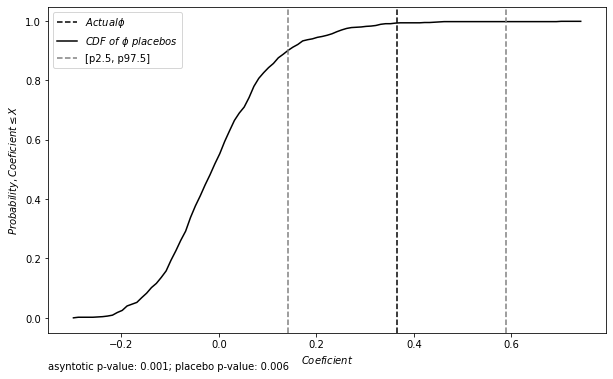

In [ ]:
# Crear el line plot
plt.figure(figsize=(10, 6))  # Cambia el tamaño según necesites
modelp = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']]).fit().summary2()

truec = modelp.tables[1][["Coef.", "[0.025", "0.975]"]].loc["XT"]["Coef."]
true_is = modelp.tables[1][["Coef.", "[0.025", "0.975]"]].loc["XT"]["0.975]"]
true_ii = modelp.tables[1][["Coef.", "[0.025", "0.975]"]].loc["XT"]["[0.025"]

pvalue_ols = round(modelp.tables[1][["Coef.", "[0.025", "0.975]", "P>|t|"]].loc["XT"]["P>|t|"],3)
pvalue_placebo = round(1 - ((placebos["XT"] <= truec).sum() / NPLA),3)

plt.axvline(x=truec, color='black', linestyle='--', label = r"$Actual \phi$")

plt.plot(placebos_cdf['coef'], placebos_cdf['P<=coef'], label=r"$CDF \ of \ \phi  \ placebos$", color ="black")

plt.axvline(x=true_ii, color='gray', linestyle='--', label = "[p2.5, p97.5]")
plt.axvline(x=true_is, color='gray', linestyle='--')

plt.xlabel(r'$Coeficient$')  # Etiqueta del eje X
plt.ylabel(r'$Probability,Coeficient \leq X$')  # Etiqueta del eje Y
# plt.title('Line Plot de placebos_cdf con Líneas Verticales')  # Título del gráfico
plt.legend()  # Muestra la leyenda

plt.text(0, -0.12, f'asyntotic p-value: {pvalue_ols}; placebo p-value: {pvalue_placebo}', transform=plt.gca().transAxes, ha='left', va='bottom')


# Mostrar el gráfico
plt.show()

### Placebo suponiendo los repitentes en 2011

In [ ]:
X11 = pd.read_excel("2011_X.xlsx)

## Regresión (motivación): consejo + margen

In [317]:
d = df[(df.date==año)]

limite1 = 1
threshold1 = 0

limite2 = 1
# threshold2 = d[f"curules_share_{año_t1}"].median()
threshold2 = 0.5

año = año_t1+1

d["Y"] = d["deuda_pc"]
d["const"] = 1
d["X1"] = d[f"diferencia_{año_t1}"].copy()
d["X2"] = d[f"curules_share_{año_t1}"] - threshold2
d["X1X2"] = d["X1"]*d["X2"]
d["T1"] = np.where(d["X1"] >= 0, 1, 0)
d["T2"] = np.where(d["X2"] >= 0, 1, 0)
d["T1T2"] = d["T1"]*d["T2"]
d["X1T1"] = d["X1"] * d["T1"]
d["X2T2"] = d["X2"] * d["T2"]
d["X1X2T1"] = d["X1"] * d["X2"] * d["T1"]
d["X1X2T2"] = d["X1"] * d["X2"] * d["T2"]
d["X1X2T1T2"] = d["X1"] * d["X2"] * d["T1"] * d["T2"]

d = d[np.abs(d.X1)<1]
d = d[np.abs(d.X1)<1]
d = d.dropna()

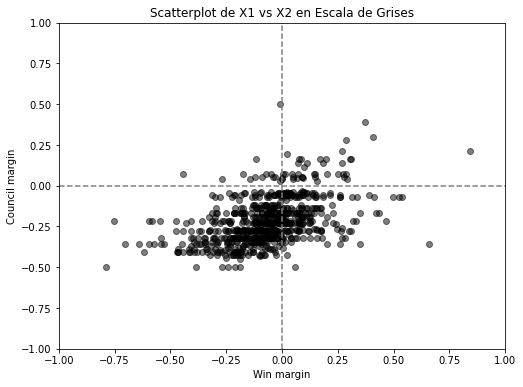

In [320]:
# Ajustar el scatterplot con límites específicos en los ejes y colores en escala de grises

plt.figure(figsize=(8, 6))
plt.scatter(d["X1"], d["X2"], color='black', alpha=0.5)  # Scatterplot de X1 vs X2

# Dibujar una línea vertical en X=0 y una horizontal en Y=0, también en escala de grises
plt.axvline(x=0, color='gray', linestyle='--')  # Línea vertical en negro
plt.axhline(y=0, color='gray', linestyle='--')  # Línea horizontal en negro

# Establecer los límites para los ejes según lo solicitado
plt.xlim(-1, 1)  # Límites para X1
plt.ylim(-1, 1)  # Límites para X2

# Títulos y etiquetas
# plt.title('Scatterplot de X1 vs X2 en Escala de Grises')
plt.xlabel('Win margin')
plt.ylabel('Council margin')

# Mostrar el gráfico
plt.show()


In [319]:

# # Variables para el modelo
variables_modelo = ["const", "X1", "X2", "T1", "T2", "X1X2", "X1T1", "X2T2"] 
model = sm.OLS(d["Y"],d[variables_modelo]).fit()
coeficientes = model.params

from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interactive, widgets

x1_valores = np.linspace(-1, 1, 100)
x2_valores = np.linspace(-1, 1, 100)
X1_mesh, X2_mesh = np.meshgrid(x1_valores, x2_valores)

    # Definir T1 y T2 basado en las condiciones
T1_mesh = (X1_mesh >= 0).astype(int)
T2_mesh = (X2_mesh >= 0).astype(int)

    # Calcular Y predicho en la grilla basado en los coeficientes
Y_pred_mesh = (coeficientes['const'] +
                   coeficientes['X1'] * X1_mesh +
                   coeficientes['X2'] * X2_mesh +
                   coeficientes['T1'] * T1_mesh +
                   coeficientes['T2'] * T2_mesh +
                   coeficientes['X1X2'] * X1_mesh * X2_mesh +
                   coeficientes['X1T1'] * X1_mesh * T1_mesh +
                   coeficientes['X2T2'] * X2_mesh * T2_mesh)


import plotly.graph_objects as go

# Definir los datos para el gráfico
fig = go.Figure(data=[go.Surface(x=X1_mesh, y=X2_mesh, z=Y_pred_mesh, colorscale='YlOrRd')])

# Actualizar el diseño del gráfico
fig.update_layout(
    title=None,
    autosize=False,
    width=800,  # Ajustado para hacer el dibujo más grande
    height=600,  # Ajustado para hacer el dibujo más grande
    margin=dict(l=65, r=50, b=65, t=90),
    scene=dict(  # Personalizar los nombres de los ejes
        xaxis_title='Win margin',
        yaxis_title='Council share',
        zaxis_title='Debt')
)

fig.show()

## Regresion consejo

In [177]:
lista_controles = list(controles.columns)

Organización base + parametros

In [223]:
#PARAMETROS
# d["X"] = 1 + d[f"diferencia_{año_t1}"].copy()
# threshold = 1
# limite = 2



# d = df[(df.date >= año) & (df.date <= año+4)]
d = df[(df.date==año)]


limite1 = 1
threshold1 = 0

limite2 = 1
threshold2 = d[f"curules_share_{año_t1}"].median()

año = año_t1+1
d["Y"] = d["deuda_pc"]
d["X1"] = d[f"diferencia_{año_t1}"].copy()
d["X2"] = d[f"curules_share_{año_t1}"] - threshold2
d = d[np.abs(d.X1)<1]
d = d[np.abs(d.X1)<2]

# # Crear las variables T1, T2, X1T1, X2T2, X1X2T1, X1X2T2, X1X2T1T2
# d["T1"] = np.where(d["X1"] >= 0, 1, 0)
# d["T2"] = np.where(d["X2"] >= 0, 1, 0)
# d["X1T1"] = d["X1"] * d["T1"]
# d["X2T2"] = d["X2"] * d["T2"]
# d["X1X2T1"] = d["X1"] * d["X2"] * d["T1"]
# d["X1X2T2"] = d["X1"] * d["X2"] * d["T2"]
# d["X1X2T1T2"] = d["X1"] * d["X2"] * d["T1"] * d["T2"]

# # Variables para el modelo
# variables_modelo = ["X1", "X2", "T1", "T2", "X1T1", "X2T2", "X1X2T1", "X1X2T2", "X1X2T1T2"]

# # Ajustando una regresión lineal con la constante
# X = d[variables_modelo]
# X = sm.add_constant(X)
# model = OLS(d["Y"], X).fit()

# # Coeficientes del modelo
# coeficientes = model.params
# coeficientes



# dd = d[["Y", "X", "coal", "cons"]+lista_controles].dropna()
# dd = dd[np.abs(dd["X"])<=limite]
# dd['const'] = 1

# dd["T"] = 
# dd['XT'] = dd['X'] * dd['T']

# dd['Tcons'] = dd['T'] * dd['cons']
# dd['Xcons'] = dd['X'] * dd['cons']
# dd['XTcons'] = dd['XT'] * dd['cons']



# # dd["Xa"] = np.abs(dd["X"].copy())
# # dd['XaT'] = dd['Xa'] * dd['T']

# # dd = dd[dd["T"] ==1]
# est1 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "uniform", all = True, h = 100, vce='hc0',  c=threshold)
# est1 = rdrobust(y=dd["Y"], x=dd["X"], p=1, deriv=1, kernel = "uniform", all = True, vce='hc0',  c=threshold)
# b_optimo = est1.bws.loc["b"][0]
# # sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']]).fit().summaty()
# # sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']]).fit(cov_type="HC3").summary2()
# # A = sm.OLS(dd['Y'], dd[['const', 'X', 'T', 'XT']])
# # A.fit?



## Regresión: Consejo + Council

In [225]:
d['Xo1'] = d.apply(lambda fila: fila['X1'] * fila['X2'] if (fila['X1'] >= 0 and fila['X2'] >= 0) else -abs(fila['X1'] * fila['X2']), axis=1)
d['Xo2'] = d.apply(lambda fila: min(fila['X1'], fila['X2']) if fila['X1'] >= 0 and fila['X2'] >= 0 else -abs(min(fila['X1'], fila['X2'])), axis=1)



In [229]:
# Re-definimos las funciones para calcular la distancia de un punto al origen
def distancia_manhattan_al_origen_con_signo(x1, x2):
    distancia = abs(x1) + abs(x2)
    if x1 < 0 or x2 < 0:
        distancia *= -1
    return distancia

def distancia_euclidiana_al_origen_con_signo(x1, x2):
    distancia = math.sqrt(x1**2 + x2**2)
    if x1 < 0 or x2 < 0:
        distancia *= -1
    return distancia

# Aplicar las funciones a las columnas 'X1' y 'X2' del DataFrame
d['Xo3'] = d.apply(lambda fila: distancia_manhattan_al_origen_con_signo(fila['X1'], fila['X2']), axis=1)
d['Xo4'] = d.apply(lambda fila: distancia_euclidiana_al_origen_con_signo(fila['X1'], fila['X2']), axis=1)


X = "Xo4"


In [230]:
d["X"] = d[X].copy()
d["T"] = d["X"].apply(lambda x: 1 if x>=0 else 0)
d["XT"] = d["X"]*d["T"]
dd = d[["Y","T", "X", "XT"]].dropna()
dd["const"] = 1

In [231]:
sm.OLS(np.log(1+dd['Y']), dd[['const', 'X', 'T', 'XT']]).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.022     
Dependent Variable: Y                AIC:                -1159.8824
Date:               2024-04-11 10:09 BIC:                -1141.6383
No. Observations:   707              Log-Likelihood:     583.94    
Df Model:           3                F-statistic:        6.250     
Df Residuals:       703              Prob (F-statistic): 0.000344  
R-squared:          0.026            Scale:              0.011287  
----------------------------------------------------------------------
          Coef.     Std.Err.       t       P>|t|      [0.025    0.975]
----------------------------------------------------------------------
const     0.0641      0.0085     7.5776    0.0000     0.0475    0.0807
X         0.0005      0.0350     0.0134    0.9893    -0.0683    0.0692
T        -0.0298      0.0161    -1.8468    0.0652    -0.0614    0.0019
XT        0.2082      0.0627     3.3201    0.0009     0.0851    0.3313
-------------------------------------------------------------------
Omnibus:              792.273      Durbin-Watson:         1.970    
Prob(Omnibus):        0.000        Jarque-Bera (JB):      93413.562
Skew:                 5.129        Prob(JB):              0.000    
Kurtosis:             58.370       Condition No.:         17       
===================================================================

"""

In [233]:
np.random.uniform(0.5, 1, 2)  # A and B positive

array([0.8654279 , 0.62697082])